In [1]:
import matplotlib.pyplot as plt
import numpy as np
import simulations as nb

from src import acf_utils, timescale_utils, sim, plts

# set notebook defaults
np.set_printoptions(precision=2)
%load_ext autoreload
%autoreload 2

random_seed = 1
n_regions, n_timepoints = 1, 1200
sampling_rate = 1 / 0.75

# initialize estimators
ols = timescale_utils.OLS(n_jobs=-2)
nls = timescale_utils.NLS(n_jobs=-2)

**estimating timescales: ols vs nls**

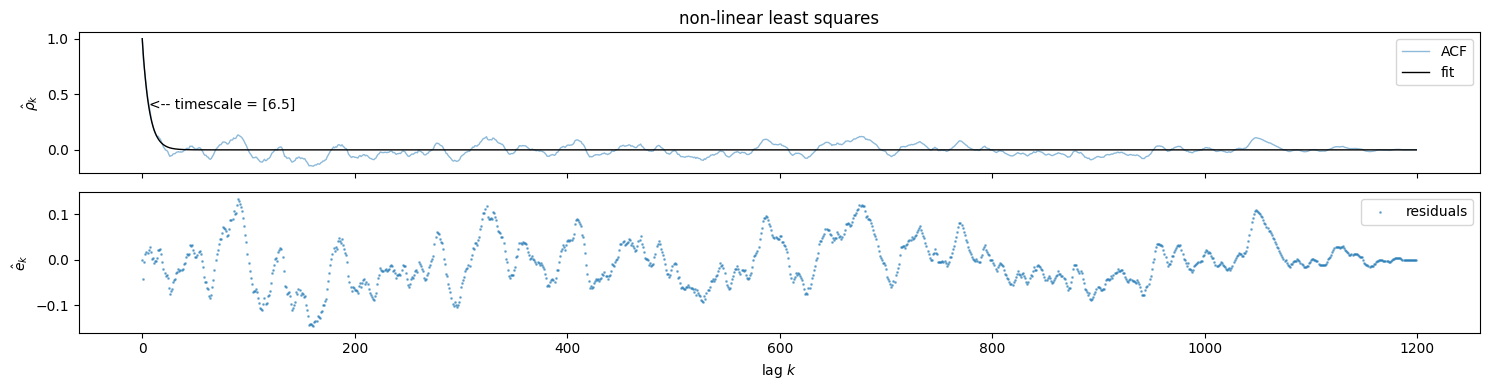

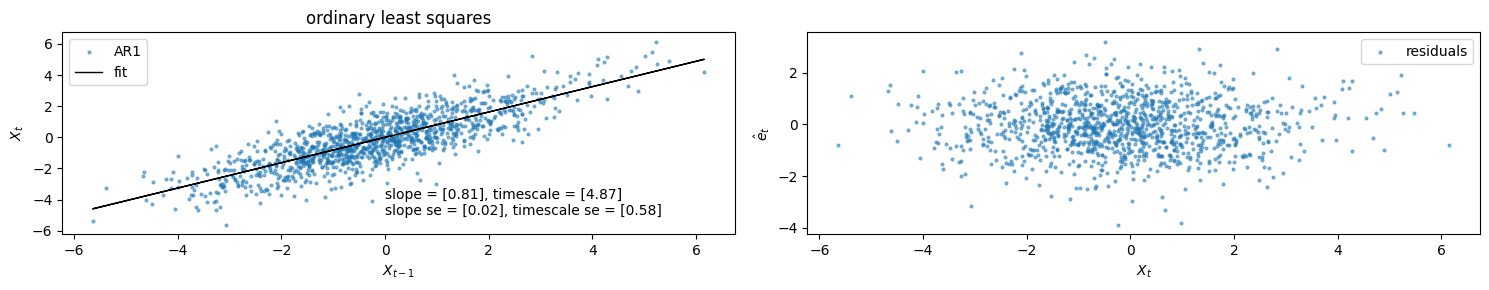

In [2]:
X = sim.sim_ar([0.646, 0.193], n_timepoints)  # AR(2)

nls_ = nls.fit(X, n_timepoints)
ols_ = ols.fit(X, n_timepoints)
nb.plot_nls_vs_ols(X, n_timepoints, nls_, ols_)

**simulations of AR(1), AR(2), and fMRI-derived processes**

In [3]:
# set fixed parameters #
n_timepoints, n_repeats = 4800, 1000

# AR(1) #
ar1_phis = np.linspace(0.1, 0.8, 5)
ar1_taus = -1 / np.log(ar1_phis)
ar1_exp_taus = ar1_taus

# AR(2) #
ar2_phis = np.array([[0.091, 0.09], [0.229, 0.182], [0.347, 0.229], [0.471, 0.24], [0.646, 0.193]])
ar2_exp_taus = np.array([0.47399, 1.06288, 1.94677, 3.38165, 6.63089])

# HCP #
acf = acf_utils.ACF()
X_hcp = (
    np.load("./data/nsubjects-10_nregions-300_hcp.npy")
    .astype(np.float32)[1, :, [142, 125, 136, 6, 11]]  # phi in {0.1, 0.28, 0.45, 0.62, 0.8}
    .T
)
acf_ = acf.fit_transform(X_hcp, X_hcp.shape[0])
acm_ = acf_utils.acf_to_toeplitz(acf_, acf_.shape[0])
hcp_exp_taus = np.array([0.45659, 1.16799, 2.81284, 3.17746, 4.86025])  # exp(-k/tau) fit or acf_

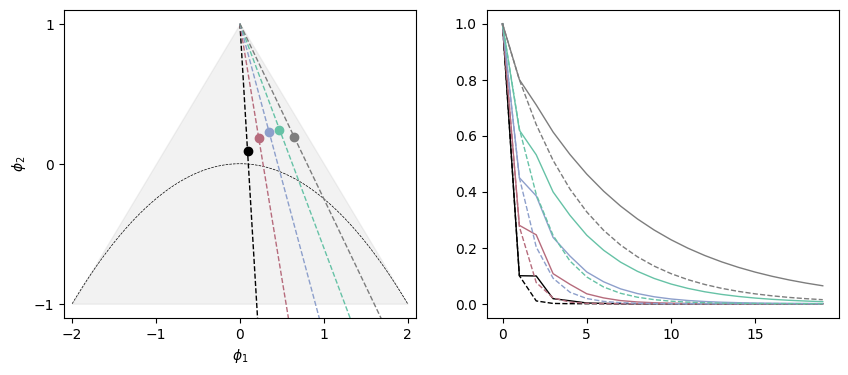

In [4]:
n_lags = 20
colors = ["#000000", "#B66B7C", "#8D9FCB", "#66C2A6", "#7D7D7D"]

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
plts.plot_stationarity_triangle(axs[0], fill_alpha=0.1, annotate=False)
for idx in range(5):
    # AR(2) triangle
    phi1 = np.linspace(0, 2, 100)
    phi2 = 1 - phi1 / ar1_phis[idx]
    axs[0].plot(phi1, phi2, c=colors[idx], ls="--", lw=1)
    axs[0].scatter(ar2_phis[idx, 0], ar2_phis[idx, 1], c=colors[idx])

    # AR(2) acf
    ar1_acf = acf_utils.ar_to_acf(ar1_phis[idx], n_lags=n_lags)
    ar2_acf = acf_utils.ar_to_acf(ar2_phis[idx, :], n_lags=n_lags)
    axs[1].plot(ar1_acf, c=colors[idx], lw=1, ls="--")
    axs[1].plot(ar2_acf, c=colors[idx], lw=1)

In [5]:
# !! 25sec runtime !!

# AR(1) #
ar1_estimates_ = nb.mc_simulation(ar1_phis, n_timepoints, random_seed=42)

# AR(2) #
ar2_estimates_ = nb.mc_simulation(ar2_phis, n_timepoints, random_seed=42)

# HCP #
hcp_estimates_ = nb.mc_simulation(ar1_phis, n_timepoints, acm=acm_, random_seed=42)

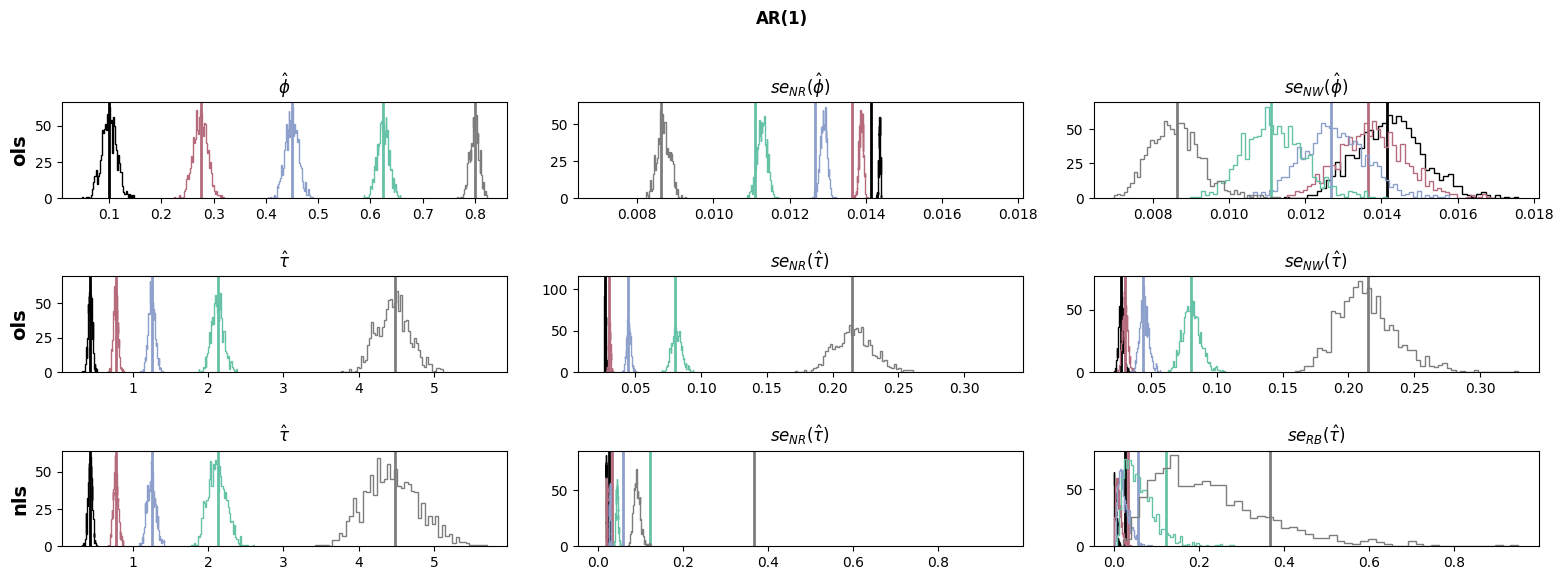

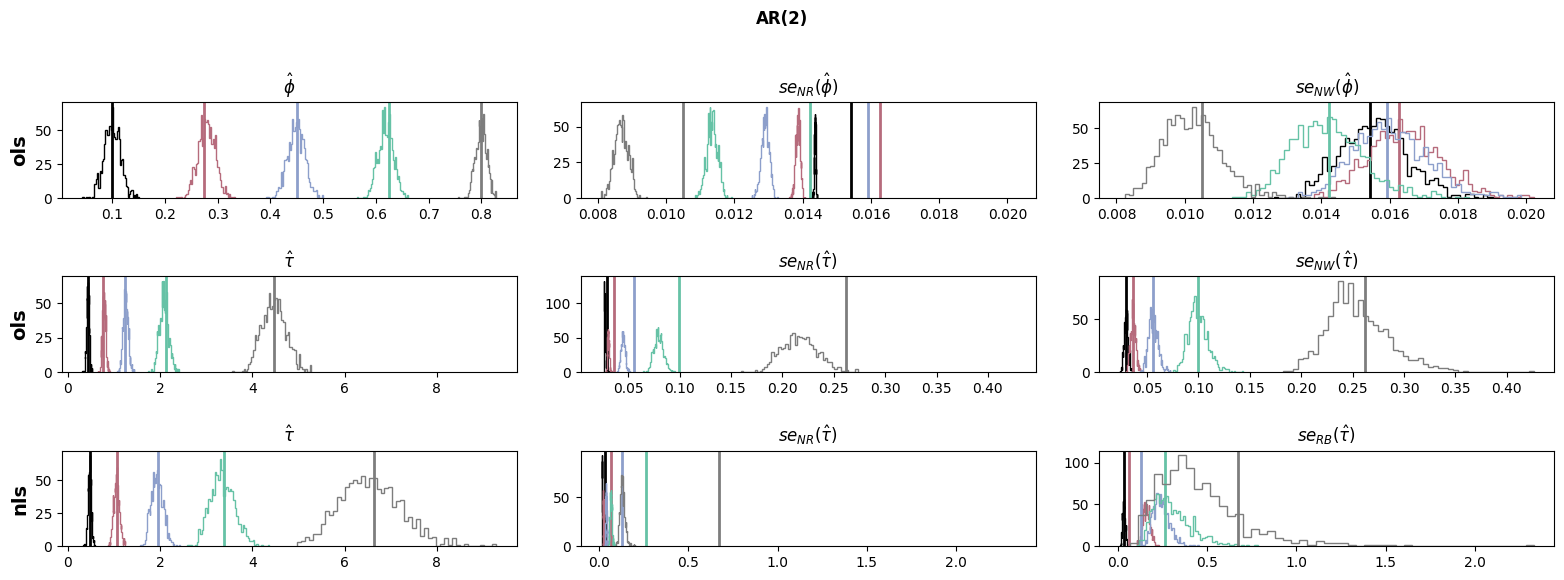

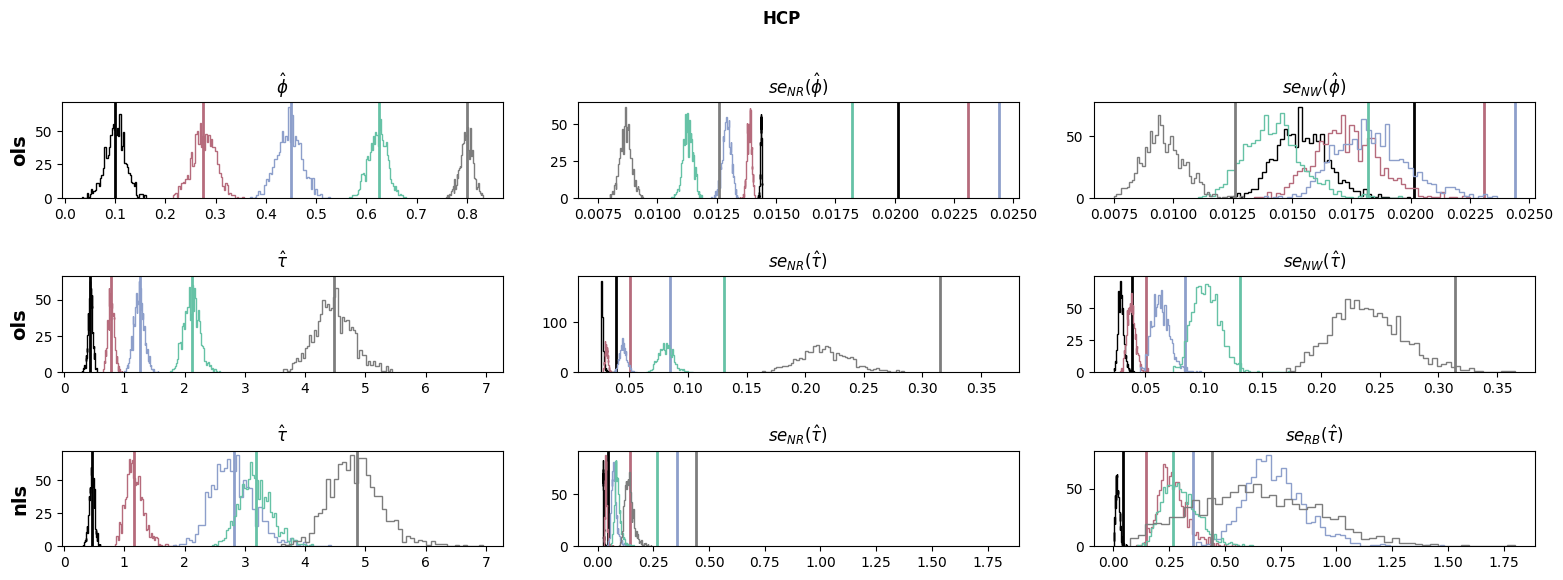

In [6]:
nb.plot_simulation(ar1_estimates_, ar1_phis, ar1_taus, ar1_exp_taus, fig_title="AR(1)")
nb.plot_simulation(ar2_estimates_, ar1_phis, ar1_taus, ar2_exp_taus, fig_title="AR(2)")
nb.plot_simulation(hcp_estimates_, ar1_phis, ar1_taus, hcp_exp_taus, fig_title="HCP")